#### In this notebook I'll use a 4 lstm layers neural net, in order to build a flexible model than can capture different dependencies between elements of each chemical string, along with dropout layers to fight overfitting

#### Also we'll use Bayesian optimization to fine-tune hyperparameters of our model. Bayesian optimization utilizes knowledge from past trials to make informed decisions, resulting in faster optimization times and improved results.

In [412]:
# importing all helper functions from the first notebook
%run helper.ipynb

In [5]:
# usage of bayesian search and execution on collab
from keras_tuner import HyperModel
import keras_tuner
import tensorflow as tf

In [1]:
!pip install keras_preprocessing
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 812.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.4 MB/s eta 0:00:00


In [ ]:
class Model(HyperModel):
  def build(self, hp):
    units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    dropout1 = hp.Float(name="dropout1", min_value=0.0, max_value=0.3, step=0.05)
    units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    dropout2 = hp.Float(name="dropout2", min_value=0.0, max_value=0.3, step=0.05)
    units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
    dropout3 = hp.Float(name="dropout3", min_value=0.0, max_value=0.3, step=0.05)
    units4 = hp.Int('units4', min_value=32, max_value=512, step=32)
    dropout4 = hp.Float(name="dropou4", min_value=0.0, max_value=0.3, step=0.05)
    units5 = hp.Int('units5', min_value=32, max_value=512, step=32)
    dropout5 = hp.Float(name="dropout5", min_value=0.0, max_value=0.3, step=0.05)
    model = Sequential()
    model.add(LSTM(units = units1, return_sequences= True, input_shape = (x_train.shape[1:])))
    model.add(Dropout(dropout1))
    model.add(LSTM(units = units2, return_sequences=True))
    model.add(Dropout(dropout2))
    model.add(LSTM(units = units3, return_sequences = True))
    model.add(Dropout(dropout3))
    model.add(LSTM(units = units4, return_sequences=True))
    model.add(Dropout(dropout4))
    model.add(LSTM(units = units5))
    model.add(Dropout(dropout5))
    model.add(Dense(units=vocab_size+1, activation = 'softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
from math import prod
hypermodel = Model()
tuner = keras_tuner.BayesianOptimization(
                        hypermodel=hypermodel,
                        objective = "val_accuracy",
                        max_trials =3, #The maximum number of hyperparameter combinations to try
                        overwrite=True,
                        directory='BO_search_dir',
                        project_name='better_lstm',
                        )
# Tune the model

tuner.search(x_train, y_train_2, epochs=3, validation_data=(x_val, y_val_2))
best_model = tuner.get_best_models()[0]
best_model.build(input_shape= (x_train.shape[1:]))
best_model.summary()
print(tuner.results_summary())

Trial 3 Complete [00h 55m 31s]
val_accuracy: 0.7102004289627075

Best val_accuracy So Far: 0.7102004289627075
Total elapsed time: 02h 43m 17s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 15, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 15, 352)           1217920   
                                                                 
 dropout_1 (Dropout)         (None, 15, 352)           0         
                                                                 
 lstm_2 (LSTM)               (None, 15, 128)           246272    
                                                                 
 dropout_2 (Dropout)         (None, 15, 128)  

## Train the model on generic data

In [2]:
print("x_train shape :", x_train.shape)
print("y_train shape :", y_train.shape)
print("x_val shape :", x_val.shape)
print("y_val shape :", y_val.shape)

x_train shape : (4532385, 15, 1)
y_train shape : (4532385, 1)
x_val shape : (503585, 15, 1)
y_val shape : (503585, 1)


In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [6]:
train_dataset.element_spec

(TensorSpec(shape=(15, 1), dtype=tf.int32, name=None),
 TensorSpec(shape=(1,), dtype=tf.int32, name=None))

In [11]:
train_dataset_batch = train_dataset.batch(128, drop_remainder = True)
val_dataset_batch = val_dataset.batch(128, drop_remainder = True)

In [10]:
train_dataset_batch.element_spec

(TensorSpec(shape=(128, 15, 1), dtype=tf.int32, name=None),
 TensorSpec(shape=(128, 1), dtype=tf.int32, name=None))

In [22]:
import tensorflow as tf
improved_lstm_generic_data = tf.keras.Sequential([
    tf.keras.layers.LSTM(512, input_shape=x_train.shape[1:], return_sequences=True),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.LSTM(352, return_sequences=True),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.LSTM(416, return_sequences=True),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.LSTM(288),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(vocab_size+1, activation='softmax')
])

improved_lstm_generic_data.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])
print(improved_lstm_generic_data.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 15, 512)           1052672   
                                                                 
 dropout_10 (Dropout)        (None, 15, 512)           0         
                                                                 
 lstm_11 (LSTM)              (None, 15, 352)           1217920   
                                                                 
 dropout_11 (Dropout)        (None, 15, 352)           0         
                                                                 
 lstm_12 (LSTM)              (None, 15, 128)           246272    
                                                                 
 dropout_12 (Dropout)        (None, 15, 128)           0         
                                                                 
 lstm_13 (LSTM)              (None, 15, 416)          

In [12]:
# Train the improved model on the generic dataset
from tensorflow.keras.callbacks import EarlyStopping
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5) 
history = improved_lstm_generic_data.fit(train_dataset_batch,epochs = 40, validation_data=val_dataset_batch, verbose=1, callbacks = [early])
path1 = "c:\\users\\talibit\\Drug_discovery_data\\models\\improved_lstm_generic_data.h5"
path2 = "c:\\users\\talibit\\Drug_discovery_data\\graphs\\improved_lstm_generic_data.png"
improved_lstm_generic_data.save(path1) 
generate_curves(history, path2)

Epoch 1/40
35409/35409 [==============================] - 92165s 3s/step - loss: 0.8915 - accuracy: 0.7010 - val_loss: 0.7889 - val_accuracy: 0.7308
Epoch 2/40
35409/35409 [==============================] - 23865s 674ms/step - loss: 0.7408 - accuracy: 0.7456 - val_loss: 0.6991 - val_accuracy: 0.7580
Epoch 3/40
35409/35409 [==============================] - 20693s 584ms/step - loss: 0.7132 - accuracy: 0.7543 - val_loss: 0.6810 - val_accuracy: 0.7642
Epoch 4/40
35409/35409 [==============================] - 20641s 583ms/step - loss: 0.7021 - accuracy: 0.7579 - val_loss: 0.6732 - val_accuracy: 0.7667
Epoch 5/40
35409/35409 [==============================] - 37663s 1s/step - loss: 0.6949 - accuracy: 0.7601 - val_loss: 0.6709 - val_accuracy: 0.7674
Epoch 6/40
35409/35409 [==============================] - 20439s 577ms/step - loss: 0.6923 - accuracy: 0.7608 - val_loss: 0.6693 - val_accuracy: 0.7687
Epoch 7/40
35409/35409 [==============================] - 58429s 2s/step - loss: 0.6905 - accu

C:\Users\talibit\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


NameError: name 'plt' is not defined

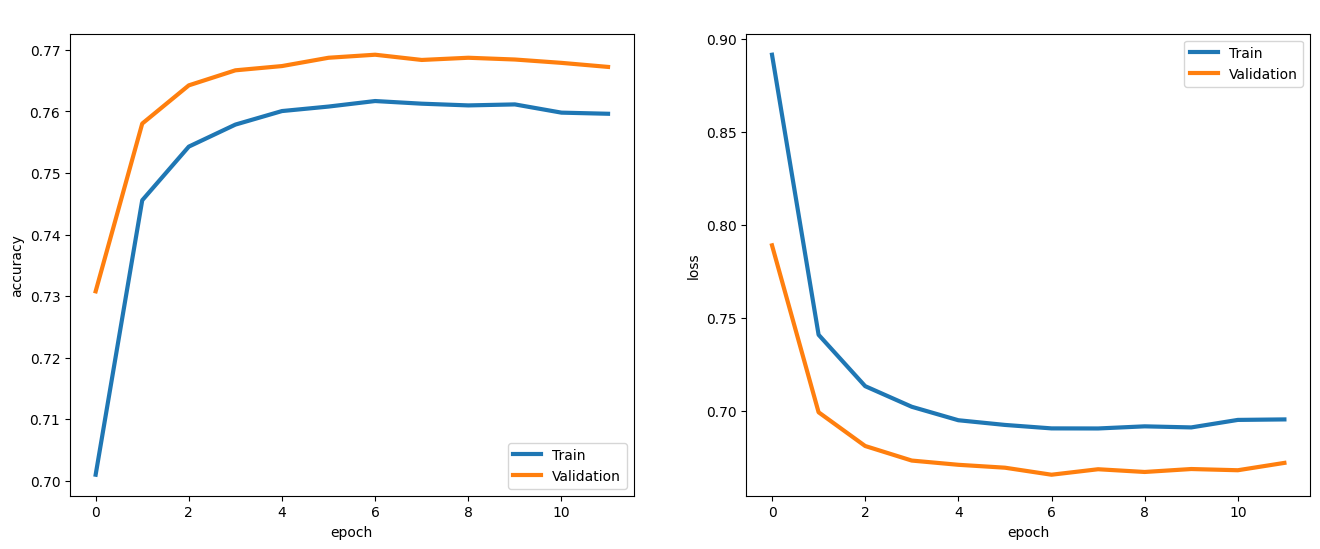

In [14]:
import matplotlib.pyplot as plt
generate_curves(history, path2)

I arrived here
I arrived here
I arrived here
I arrived here
I arrived here

## So with the improved model the val_accuracy on the generic dataset has increased from : 65.8%  to 76.7%

## Let's train the imporved model on the alzheimer dataset without transfert learning

In [17]:
#check the alzheimer dataset:
print("x_train shape :", x_train1.shape)
print("y_train shape :", y_train1.shape)
print("x_val shape :", x_val1.shape)
print("y_val shape :", y_val1.shape)

x_train shape : (30435, 15, 1)
y_train shape : (30435, 1)
x_val shape : (3385, 15, 1)
y_val shape : (3385, 1)


In [18]:
train_dataset1 = tf.data.Dataset.from_tensor_slices((x_train1, y_train1))
val_dataset1 = tf.data.Dataset.from_tensor_slices((x_val1, y_val1))

In [19]:
train_dataset1.element_spec

(TensorSpec(shape=(15, 1), dtype=tf.int32, name=None),
 TensorSpec(shape=(1,), dtype=tf.int32, name=None))

In [20]:
train_dataset_batch1 = train_dataset1.batch(128, drop_remainder = True)
val_dataset_batch1 = val_dataset1.batch(128, drop_remainder = True)

In [21]:
train_dataset_batch1.element_spec

(TensorSpec(shape=(128, 15, 1), dtype=tf.int32, name=None),
 TensorSpec(shape=(128, 1), dtype=tf.int32, name=None))

Epoch 1/40
237/237 [==============================] - 188s 772ms/step - loss: 2.6033 - accuracy: 0.2736 - val_loss: 2.3997 - val_accuracy: 0.3456
Epoch 2/40
237/237 [==============================] - 164s 692ms/step - loss: 2.0609 - accuracy: 0.3847 - val_loss: 1.6551 - val_accuracy: 0.4892
Epoch 3/40
237/237 [==============================] - 155s 655ms/step - loss: 1.3654 - accuracy: 0.5725 - val_loss: 1.2098 - val_accuracy: 0.6226
Epoch 4/40
237/237 [==============================] - 160s 674ms/step - loss: 1.0461 - accuracy: 0.6679 - val_loss: 0.9528 - val_accuracy: 0.7001
Epoch 5/40
237/237 [==============================] - 153s 646ms/step - loss: 0.8595 - accuracy: 0.7215 - val_loss: 0.8533 - val_accuracy: 0.7341
Epoch 6/40
237/237 [==============================] - 149s 628ms/step - loss: 0.7564 - accuracy: 0.7534 - val_loss: 0.7574 - val_accuracy: 0.7548
Epoch 7/40
237/237 [==============================] - 146s 618ms/step - loss: 0.6540 - accuracy: 0.7852 - val_loss: 0.7158 -

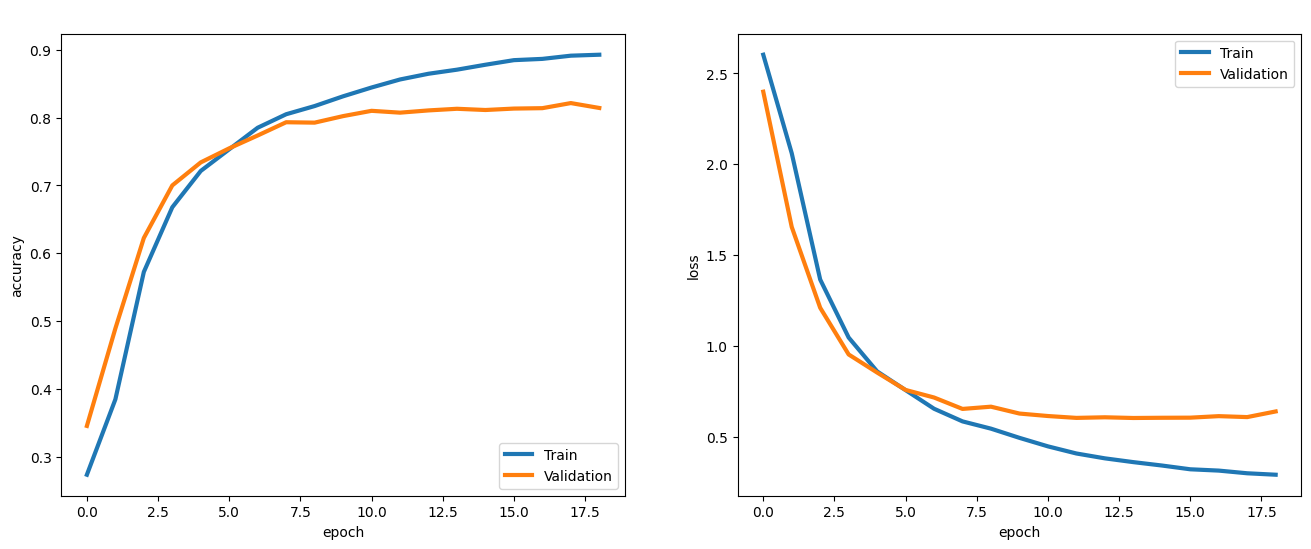

In [23]:
# Train the improved model on the alzheimer dataset
from tensorflow.keras.callbacks import EarlyStopping
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5) 
history = improved_lstm_generic_data.fit(train_dataset_batch1,epochs = 40, validation_data=val_dataset_batch1, verbose=1, callbacks = [early])
path1 = "c:\\users\\talibit\\Drug_discovery_data\\models\\improved_lstm_alzheimer_data.h5"
path2 = "c:\\users\\talibit\\Drug_discovery_data\\graphs\\improved_lstm_alzheimer_data.png"
improved_lstm_generic_data.save(path1)
import matplotlib.pyplot as plt
generate_curves(history, path2)

## the val_accuracy has improved from 61.21% (for the baseline model) to  81.43% (for the imporved model)

## let's now train the lstm improved model on alzheimer dataset with transfert learning¶

In [129]:
from tensorflow.keras.models import load_model

In [130]:
model = load_model("C:\\Users\\talibit\\Drug_discovery_data\\models\\improved_lstm_generic_data.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 15, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 15, 352)           1217920   
                                                                 
 dropout_1 (Dropout)         (None, 15, 352)           0         
                                                                 
 lstm_2 (LSTM)               (None, 15, 128)           246272    
                                                                 
 dropout_2 (Dropout)         (None, 15, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 15, 416)           9

In [141]:
from keras.models import Sequential
improved_lstm_alzheimer_data_TF = Sequential()

for layer in model.layers[:-1] :
    layer.trainable = False
    improved_lstm_alzheimer_data_TF.add(layer)
model.layers[-1].trainable = True
improved_lstm_alzheimer_data_TF.add( model.layers[-1])
improved_lstm_alzheimer_data_TF.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

In [142]:
improved_lstm_alzheimer_data_TF.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 15, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 15, 352)           1217920   
                                                                 
 dropout_1 (Dropout)         (None, 15, 352)           0         
                                                                 
 lstm_2 (LSTM)               (None, 15, 128)           246272    
                                                                 
 dropout_2 (Dropout)         (None, 15, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 15, 416)         

In [143]:
for index, layer in enumerate(improved_lstm_alzheimer_data_TF.layers):
    print(f"Layer {index}: {layer.name}, Trainable: {layer.trainable}")

Layer 0: lstm, Trainable: False
Layer 1: dropout, Trainable: False
Layer 2: lstm_1, Trainable: False
Layer 3: dropout_1, Trainable: False
Layer 4: lstm_2, Trainable: False
Layer 5: dropout_2, Trainable: False
Layer 6: lstm_3, Trainable: False
Layer 7: dropout_3, Trainable: False
Layer 8: lstm_4, Trainable: False
Layer 9: dropout_4, Trainable: False
Layer 10: dense, Trainable: True


In [144]:
improved_lstm_alzheimer_data_TF.compile(optimizer='adam', loss='SparseCategoricalCrossentropy',metrics  = ['accuracy'])

Epoch 1/40
237/237 [==============================] - 83s 350ms/step - loss: 2.1477 - accuracy: 0.4993 - val_loss: 1.9625 - val_accuracy: 0.5364
Epoch 2/40
237/237 [==============================] - 84s 353ms/step - loss: 1.8712 - accuracy: 0.5290 - val_loss: 1.7360 - val_accuracy: 0.5625
Epoch 3/40
237/237 [==============================] - 84s 353ms/step - loss: 1.7007 - accuracy: 0.5436 - val_loss: 1.5922 - val_accuracy: 0.5694
Epoch 4/40
237/237 [==============================] - 82s 348ms/step - loss: 1.5950 - accuracy: 0.5587 - val_loss: 1.4932 - val_accuracy: 0.5787
Epoch 5/40
237/237 [==============================] - 81s 342ms/step - loss: 1.5148 - accuracy: 0.5660 - val_loss: 1.4197 - val_accuracy: 0.5934
Epoch 6/40
237/237 [==============================] - 81s 341ms/step - loss: 1.4659 - accuracy: 0.5759 - val_loss: 1.3640 - val_accuracy: 0.6010
Epoch 7/40
237/237 [==============================] - 78s 330ms/step - loss: 1.4266 - accuracy: 0.5765 - val_loss: 1.3167 - val_ac

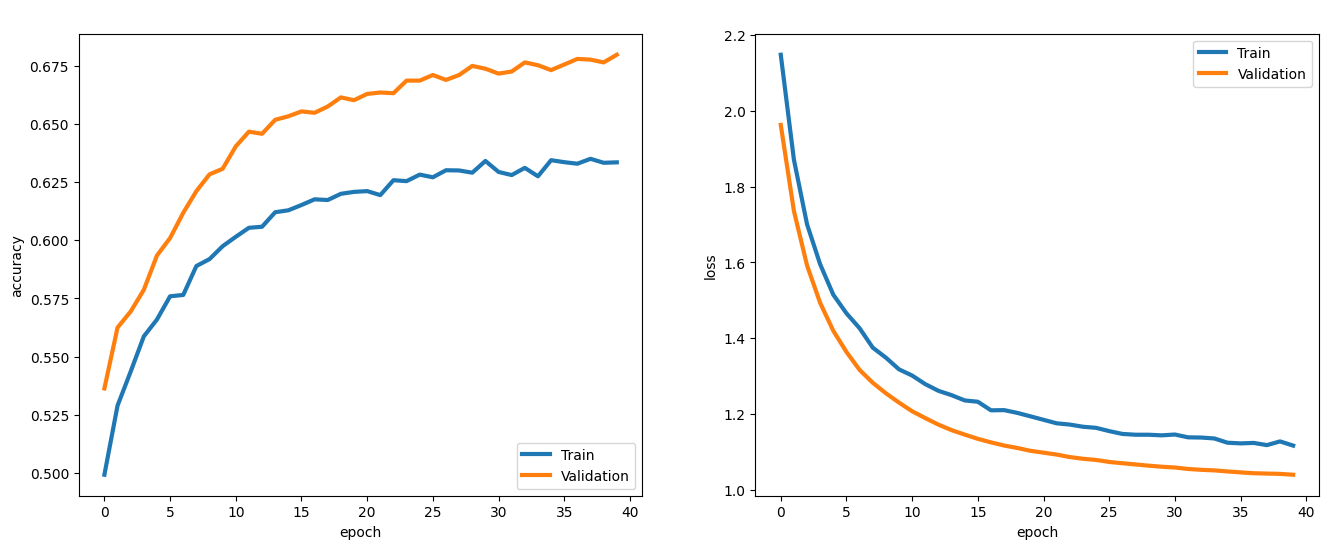

In [151]:
from tensorflow.keras.callbacks import EarlyStopping
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5) 
history = improved_lstm_alzheimer_data_TF.fit(train_dataset_batch1,epochs = 40, validation_data=val_dataset_batch1, verbose=1, callbacks = [early])
path1 = "c:\\users\\talibit\\Drug_discovery_data\\models\\improved_lstm_alzheimer_data_TF.h5"
path2 = "c:\\users\\talibit\\Drug_discovery_data\\graphs\\improved_lstm_alzheimer_data_TF.png"
improved_lstm_alzheimer_data_TF.save(path1)
import matplotlib.pyplot as plt
generate_curves(history, path2)

### so with transfert learning the val_accuracy has improved from :52.67%  to 67.97%

## let's try to freeze less layers from the pretrained model on generic data and then use it for transfert learning to retrain the model on alzheimer data

In [137]:
from keras.models import Sequential
improved_lstm_alzheimer_data_TF1 = Sequential()

for layer in model.layers[:-3] :
    layer.trainable = False
    improved_lstm_alzheimer_data_TF1.add(layer)
model.layers[-1].trainable = True
model.layers[-2].trainable = True
model.layers[-3].trainable = True
improved_lstm_alzheimer_data_TF1.add( model.layers[-3])
improved_lstm_alzheimer_data_TF1.add( model.layers[-2])
improved_lstm_alzheimer_data_TF1.add( model.layers[-1])
improved_lstm_alzheimer_data_TF1.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

In [138]:
improved_lstm_alzheimer_data_TF1.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 15, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 15, 352)           1217920   
                                                                 
 dropout_1 (Dropout)         (None, 15, 352)           0         
                                                                 
 lstm_2 (LSTM)               (None, 15, 128)           246272    
                                                                 
 dropout_2 (Dropout)         (None, 15, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 15, 416)         

In [75]:
for index, layer in enumerate(improved_lstm_alzheimer_data_TF1.layers):
    print(f"Layer {index}: {layer.name}, Trainable: {layer.trainable}")

Layer 0: lstm, Trainable: False
Layer 1: dropout, Trainable: False
Layer 2: lstm_1, Trainable: False
Layer 3: dropout_1, Trainable: False
Layer 4: lstm_2, Trainable: False
Layer 5: dropout_2, Trainable: False
Layer 6: lstm_3, Trainable: False
Layer 7: dropout_3, Trainable: False
Layer 8: lstm_4, Trainable: True
Layer 9: dropout_4, Trainable: True
Layer 10: dense, Trainable: True


Epoch 1/40
237/237 [==============================] - 69s 273ms/step - loss: 1.0617 - accuracy: 0.6544 - val_loss: 0.9355 - val_accuracy: 0.7151
Epoch 2/40
237/237 [==============================] - 66s 277ms/step - loss: 0.9932 - accuracy: 0.6753 - val_loss: 0.8811 - val_accuracy: 0.7341
Epoch 3/40
237/237 [==============================] - 62s 261ms/step - loss: 0.9314 - accuracy: 0.6932 - val_loss: 0.8421 - val_accuracy: 0.7458
Epoch 4/40
237/237 [==============================] - 62s 261ms/step - loss: 0.8919 - accuracy: 0.7071 - val_loss: 0.8009 - val_accuracy: 0.7527
Epoch 5/40
237/237 [==============================] - 62s 263ms/step - loss: 0.8563 - accuracy: 0.7164 - val_loss: 0.7722 - val_accuracy: 0.7590
Epoch 6/40
237/237 [==============================] - 62s 262ms/step - loss: 0.8186 - accuracy: 0.7291 - val_loss: 0.7442 - val_accuracy: 0.7689
Epoch 7/40
237/237 [==============================] - 62s 261ms/step - loss: 0.7919 - accuracy: 0.7385 - val_loss: 0.7268 - val_ac

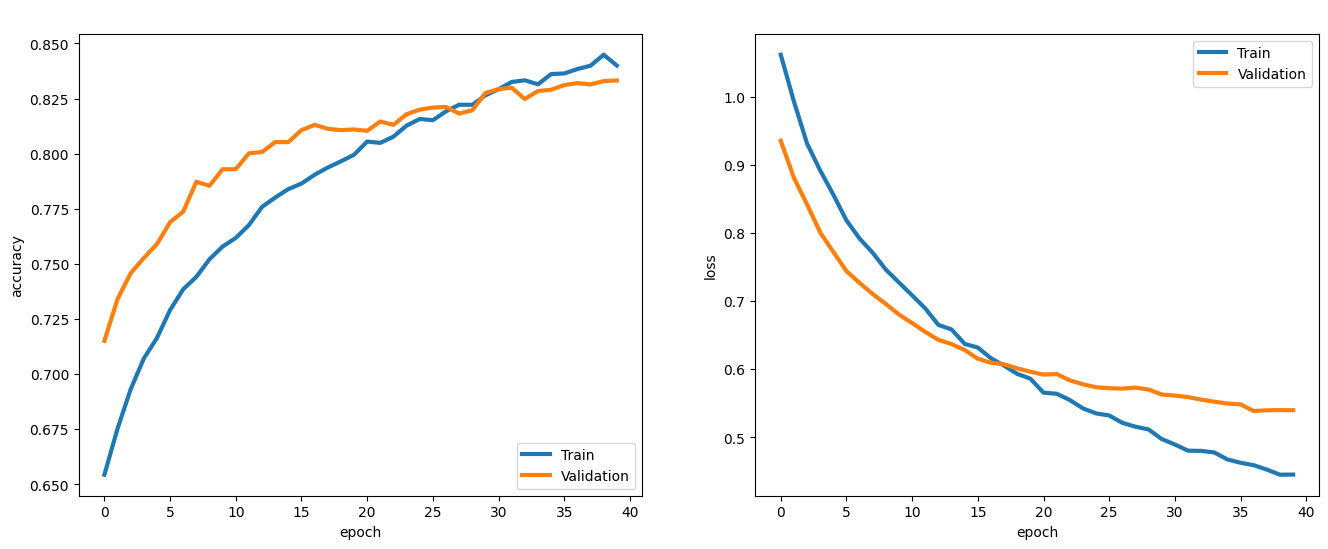

In [76]:
from tensorflow.keras.callbacks import EarlyStopping
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5) 
history = improved_lstm_alzheimer_data_TF1.fit(train_dataset_batch1,epochs = 40, validation_data=val_dataset_batch1, verbose=1, callbacks = [early])
path1 = "c:\\users\\talibit\\Drug_discovery_data\\models\\improved_lstm_alzheimer_data_TF1.h5"
path2 = "c:\\users\\talibit\\Drug_discovery_data\\graphs\\improved_lstm_alzheimer_data_TF1.png"
improved_lstm_alzheimer_data_TF1.save(path1)
import matplotlib.pyplot as plt
generate_curves(history, path2)

## So with enhanced transfert learning the val_accuracy has improved from 67.67% to 83.32%

In [139]:
# Evaluation
improved_lstm_alzheimer_data_with_TF = load_model(path1)

In [81]:
improved_lstm_alzheimer_data_with_TF.evaluate(x_test, y_test)

266/266 [==============================] - 37s 132ms/step - loss: 0.7082 - accuracy: 0.8187


[0.7081819772720337, 0.8187389373779297]

## Our model got a pretty accuracy on unseen data ( 81.87%)

## Generation of new molecules

In [419]:
#try to generate 10 molecules:

seed = 1
np.random.seed(seed)

model = improved_lstm_alzheimer_data_with_TF
ALZHEIMERS_DATA = "c:\\users\\talibit\\Drug_discovery_data\\alzheimersdata.txt"
data = np.array(list(open(ALZHEIMERS_DATA)))

smiles = []

for i in range(10):
    start = np.random.randint(0, len(data))
    seed = data[start][0:15] # this is 15 characters
    prediction = generation(seed,tokenizer1,35,model)
    smiles.append(prediction)
print(smiles)


1/1 [==============================] - 0s 31ms/step
['CCCC(=O)Nc1n[nH]c2cc(-c3ccc(O)cc3)ccc12)C1CC1£££££', 'O=C(Nc1n[nH]c2nc(-c3ccccc3)cc12£££££££££££££££££££', 'Cc1nc2ccccc2n1Cc1nnc(Nc2ccccc2Br)s1£££££££££££££££', 'Cn1c(N2CCNC(c3ccccc3Br)C2)nc(-c2ccncc2)cc1=O££££££', 'COc1ccc(-c2ocnc2C(=O)NCc2ccncc2)cc1£££££££££££££££', 'Cn1cc(C2=C(c3coc4ccccc34)C(=O)NC2=O)c2ccccc21£££££', 'CN(C)C(=O)N1CCn(CCCCC2)c3nnc(-c2ccncn2)cc(=O)n1C£$', 'O=C1Cc2c([nH]c3ccc(Br)cc23)-c2ccccc2N1££££££££££££', 'O=C1Cc2c([nH]c3ccc(Br)cc23)-c2ccccc2N1££££££££££££', 'COc1cc2c(cc1OC)CCN(c2nc(-c3ccncc3F)cc(=O)n2C)[C@H]']


In [420]:
smiles

['CCCC(=O)Nc1n[nH]c2cc(-c3ccc(O)cc3)ccc12)C1CC1£££££',
 'O=C(Nc1n[nH]c2nc(-c3ccccc3)cc12£££££££££££££££££££',
 'Cc1nc2ccccc2n1Cc1nnc(Nc2ccccc2Br)s1£££££££££££££££',
 'Cn1c(N2CCNC(c3ccccc3Br)C2)nc(-c2ccncc2)cc1=O££££££',
 'COc1ccc(-c2ocnc2C(=O)NCc2ccncc2)cc1£££££££££££££££',
 'Cn1cc(C2=C(c3coc4ccccc34)C(=O)NC2=O)c2ccccc21£££££',
 'CN(C)C(=O)N1CCn(CCCCC2)c3nnc(-c2ccncn2)cc(=O)n1C£$',
 'O=C1Cc2c([nH]c3ccc(Br)cc23)-c2ccccc2N1££££££££££££',
 'O=C1Cc2c([nH]c3ccc(Br)cc23)-c2ccccc2N1££££££££££££',
 'COc1cc2c(cc1OC)CCN(c2nc(-c3ccncc3F)cc(=O)n2C)[C@H]']

In [421]:
checkSMILES(smiles)

Cc1nc2ccccc2n1Cc1nnc(Nc2ccccc2Br)s1
Cn1c(N2CCNC(c3ccccc3Br)C2)nc(-c2ccncc2)cc1=O
COc1ccc(-c2ocnc2C(=O)NCc2ccncc2)cc1
Cn1cc(C2=C(c3coc4ccccc34)C(=O)NC2=O)c2ccccc21
O=C1Cc2c([nH]c3ccc(Br)cc23)-c2ccccc2N1
O=C1Cc2c([nH]c3ccc(Br)cc23)-c2ccccc2N1


[18:08:00] SMILES Parse Error: extra close parentheses while parsing: CCCC(=O)Nc1n[nH]c2cc(-c3ccc(O)cc3)ccc12)C1CC1
[18:08:00] SMILES Parse Error: Failed parsing SMILES 'CCCC(=O)Nc1n[nH]c2cc(-c3ccc(O)cc3)ccc12)C1CC1' for input: 'CCCC(=O)Nc1n[nH]c2cc(-c3ccc(O)cc3)ccc12)C1CC1'
[18:08:00] SMILES Parse Error: extra open parentheses for input: 'O=C(Nc1n[nH]c2nc(-c3ccccc3)cc12'
[18:08:00] SMILES Parse Error: unclosed ring for input: 'CN(C)C(=O)N1CCn(CCCCC2)c3nnc(-c2ccncn2)cc(=O)n1C'
[18:08:00] SMILES Parse Error: unclosed ring for input: 'COc1cc2c(cc1OC)CCN(c2nc(-c3ccncc3F)cc(=O)n2C)[C@H]'


['Cc1nc2ccccc2n1Cc1nnc(Nc2ccccc2Br)s1',
 'Cn1c(N2CCNC(c3ccccc3Br)C2)nc(-c2ccncc2)cc1=O',
 'COc1ccc(-c2ocnc2C(=O)NCc2ccncc2)cc1',
 'Cn1cc(C2=C(c3coc4ccccc34)C(=O)NC2=O)c2ccccc21',
 'O=C1Cc2c([nH]c3ccc(Br)cc23)-c2ccccc2N1',
 'O=C1Cc2c([nH]c3ccc(Br)cc23)-c2ccccc2N1']

# we've correctly generated 6 molecules

## We can enhance the performance of our model by first generating new Alzheimer molecules using Variational autoencoder for example, and then retrain the pretrained model on a bigger dataset